In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import numpy as np
import datetime
import rioxarray as rxr
import calendar
from datetime import date, timedelta
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import warnings
import rasterio as rio
from copy import deepcopy
from scipy.signal import detrend
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy.stats import linregress

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [2]:
SCALE = 0.0001
MVC_DIR = "AVHRR/data/AVHRR_MVC/"
MODIS_MVC_DIR = "AVHRR/data/MODIS_MVC/"
ERA5_PATH = "data/ERA5/"

In [3]:
def unpackbits(x, num_bits):
    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])

def get_date(hml):
    year_start = int(hml[0].split("/")[-1].split(".")[1][1:5])
    doy_start = int(hml[0].split("/")[-1].split(".")[1][5:8])
    doy_end = int(hml[-1].split("/")[-1].split(".")[1][5:8])
    
    return np.datetime64(date(year_start, 1, 1) + timedelta(days=(doy_start+doy_end)/2-1))

def get_filename(hml):
    year_start = int(hml[0].split("/")[-1].split(".")[1][1:5])
    doy_start = int(hml[0].split("/")[-1].split(".")[1][5:8])
    date_mvc = date(year_start, 1, 1) + timedelta(days=doy_start-1)
    if date_mvc.day <10:
        hm_symbol="a"
    else:
        hm_symbol="b"
    return "AVHRR_MVC_" + str(year_start) + '{:0>2}'.format(date_mvc.month) + hm_symbol + ".nc"

In [4]:
def get_avhrr_data(f):
    ds = rxr.open_rasterio(f)
    unpacked_qa = unpackbits(ds.QA.values[0, :, :], 16)
    iscloudy = unpacked_qa[:,:, 1].reshape(3600, 7200)==1
    iscloudyshad = unpacked_qa[:,:, 2].reshape(3600, 7200)==1
    iswater = unpacked_qa[:,:, 3].reshape(3600, 7200)==1
    isnight = unpacked_qa[:,:, 6].reshape(3600, 7200)==1
    isc1inv = unpacked_qa[:,:, 8].reshape(3600, 7200)==1
    isc2inv = unpacked_qa[:,:, 9].reshape(3600, 7200)==1
    isnobrdf = unpacked_qa[:,:, 14].reshape(3600, 7200)==0

    ismask_red = (iswater | iscloudy | iscloudyshad | isnight | isc1inv | isnobrdf)
    ismask_nir = (iswater | iscloudy | iscloudyshad | isnight | isc2inv | isnobrdf)

    red = ds.SREFL_CH1[0, :, :].values.astype(np.float32) * SCALE
    red[ismask_red] = np.nan
    nir = ds.SREFL_CH2[0, :, :].values.astype(np.float32) * SCALE
    nir[ismask_nir] = np.nan
    
    ndvi = (nir - red) / (nir + red)

    sza = ds.SZEN.values[0, :, :].astype(np.float32)
    sza[sza==-9999]=np.nan
    sza = sza * 0.01
    
    return red, nir, ndvi, sza
        
def avhrr_mvc(hml):
    lat = np.flip(np.arange(-89.975, 90, 0.05)).astype(np.float32)
    lon = np.arange(-179.975, 180, 0.05).astype(np.float32)

    MAX_NDVI = np.full((3600, 7200), -2.0, dtype=np.float32)
    BEST_RED = np.full((3600, 7200), np.nan, dtype=np.float32)
    BEST_NIR = np.full((3600, 7200), np.nan, dtype=np.float32)
    BEST_SZA = np.full((3600, 7200), np.nan, dtype=np.float32)
    
    for f in hml:
        red, nir, ndvi, sza = get_avhrr_data(f)
        BEST_RED[ndvi > MAX_NDVI] = red[ndvi > MAX_NDVI]
        BEST_NIR[ndvi > MAX_NDVI] = nir[ndvi > MAX_NDVI]
        BEST_SZA[ndvi > MAX_NDVI] = sza[ndvi > MAX_NDVI]
        MAX_NDVI[ndvi > MAX_NDVI] = ndvi[ndvi > MAX_NDVI]
        
    RED_MVC = xr.DataArray(np.expand_dims(BEST_RED, axis=0), 
                                             coords={"time":[get_date(hml)], "lat":lat, "lon":lon})

    NIR_MVC = xr.DataArray(np.expand_dims(BEST_NIR, axis=0),
                                             coords={"time":[get_date(hml)], "lat":lat, "lon":lon})

    mvc_ds = xr.Dataset({"red_brdf_normalized_sza45":RED_MVC,
                "nir_brdf_normalized_sza45":NIR_MVC})
    
    mvc_ds.to_netcdf(os.path.join(MVC_DIR, get_filename(hml)))        
    mvc_ds.close()

    for f in hml:
        os.remove(f)

In [ ]:
#IDX = int(os.getenv('SLURM_ARRAY_TASK_ID')) - 1
IDX=1
YY=np.arange(1982, 1985)[IDX]
file_list_16days = []
for year in np.arange(YY, YY+1):
    if year < 2023:
        mr = np.arange(1, 13)
    else:
        mr = np.arange(1, 7)
    for month in mr:
        days_in_month = calendar.monthrange(year, month)[1]
        for half_month_index in ["a", "b"]:
            if half_month_index == "a":
                day_range = np.arange(1, 16)
            elif half_month_index == "b":
                day_range = np.arange(16, days_in_month + 1)
            half_month_file_list = []
            for day in day_range:
                doy = date(year, month, day).timetuple().tm_yday
                fn = [f for f in AVHRR_FILES if "A"+str(year)+'{:0>3}'.format(doy) in f]
                if len(fn) > 0:
                    half_month_file_list.append(fn[0])
            file_list_16days.append(half_month_file_list)
            
#for hml in file_list_16days:
#    avhrr_mvc(hml)

### Now Cross-Sensor Calibration

In [9]:
MVC_files = []
for year in np.arange(1982, 2024):
    for month in np.arange(1, 13):
        for half_month_index in ["a", "b"]:
            MVC_files.append(os.path.join(MVC_DIR, "AVHRR_MVC_" + str(year) + '{:0>2}'.format(month) + half_month_index + ".nc"))

N07_MVC = MVC_files[0:72]
N09_MVC = MVC_files[72:164]
N11_MVC = MVC_files[164:312]
N14_MVC = MVC_files[312:452]
N16_MVC = MVC_files[452:564]
N18_MVC = MVC_files[564:658]
N19_MVC = MVC_files[658:768]
M1_MVC = MVC_files[768:]

AVHRR_MVC_LIST = [N07_MVC, N09_MVC, N11_MVC, N14_MVC, N16_MVC, N18_MVC, N19_MVC, M1_MVC]

**Caveat!** It turned out that a scan motor error occured on September 13, 1994 caused subsequent data gaps for AVHRR N11 until the end of that year when the data source is superseded by N14. Apparently this period should be left out for the correction.  


https://www.ospo.noaa.gov/Operations/POES/NOAA11/avhrr.html

In [10]:
igbp_2014=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2014001.061.2022165213124.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2014_data = igbp_2014.read()[0]
land = igbp_2014_data > 0
land_pixels = np.sum(land)
red_valid_frac = []
nir_valid_frac = []
time_list = []


with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in range(len(MVC_files)):
            ds = xr.open_dataset(MVC_files[i])
            red_valid_frac.append(np.sum(np.invert(np.isnan(ds.red_brdf_normalized_sza45[0, :, :].values))) / land_pixels)
            nir_valid_frac.append(np.sum(np.invert(np.isnan(ds.nir_brdf_normalized_sza45[0, :, :].values))) / land_pixels)
            time_list.append(ds.time[0].values)
            ds.close()
    

Text(0, 0.5, 'nir availbility fraction')

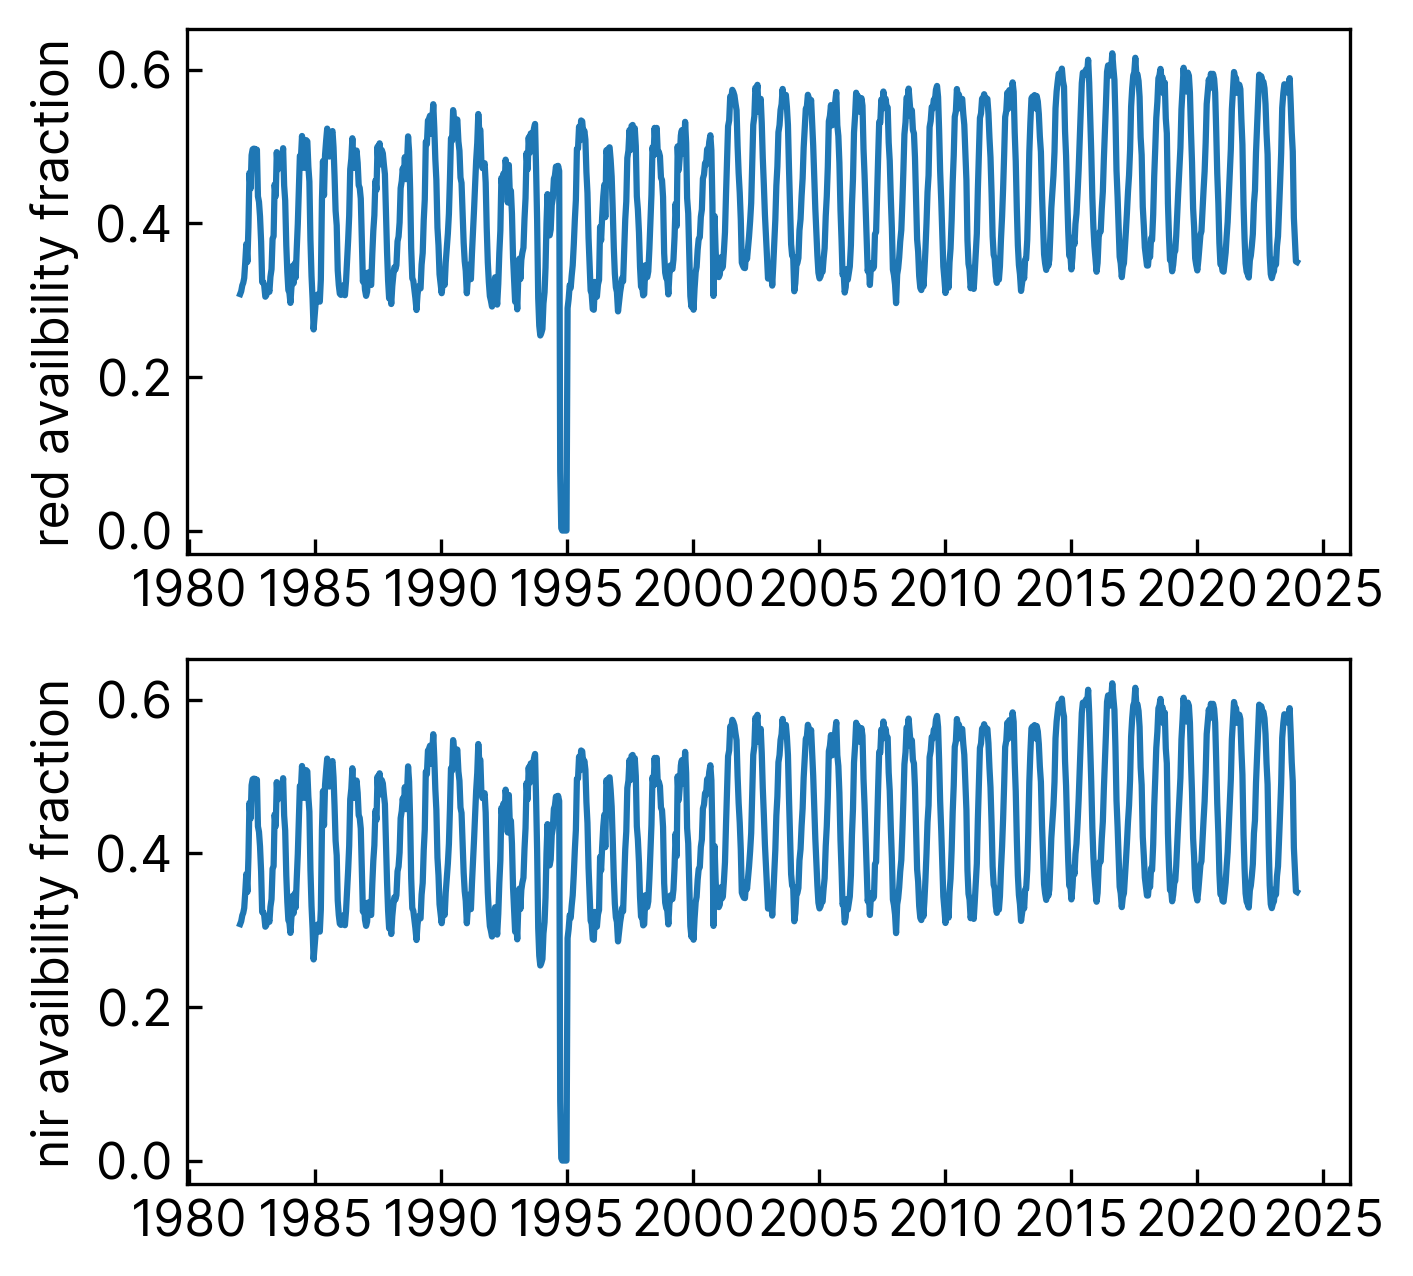

In [11]:
fig, axs = plt.subplots(2,1)
ax = axs.flatten()
ax[0].plot(time_list, red_valid_frac)
ax[0].set_ylabel("red availbility fraction")
ax[1].plot(time_list, nir_valid_frac)
ax[1].set_ylabel("nir availbility fraction")


In [12]:
#rand_idx = np.random.permutation(np.arange(20))
#cal_idx = rand_idx[:10]
#val_idx = rand_idx[10:]
#np.save("../../data/pics_cal_idx.npy", cal_idx)
#np.save("../../data/pics_val_idx.npy", val_idx)

In [13]:
pics_df = pd.read_csv("PICS.csv")
cal_idx = np.arange(20)[pics_df["usage"]=="cal"]
val_idx = np.arange(20)[pics_df["usage"]=="val"]
np.save("pics_cal_idx.npy", cal_idx)
np.save("pics_val_idx.npy", val_idx)

In [14]:
pics_df = pd.read_csv("PICS.csv")
cal_idx = np.load("pics_cal_idx.npy")
red_pics = np.zeros((len(MVC_files), 20)).astype(np.float32)
nir_pics = np.zeros((len(MVC_files), 20)).astype(np.float32)
sza_pics = np.zeros((len(MVC_files), 20)).astype(np.float32)

time_list = []

with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        for i in tqdm(range(len(MVC_files))):
            ds = xr.open_dataset(MVC_files[i])
            time_list.append(ds.time[0].values)
            for j in range(len(pics_df.index)):
                lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
                lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))

                red_pics[i, j] = np.nanmean(ds.red_brdf_normalized_sza45[0, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.flatten())
                nir_pics[i, j] = np.nanmean(ds.nir_brdf_normalized_sza45[0, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.flatten()) 
                sza_pics[i, j] = np.nanmean(ds.sza[0, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.flatten()) 

100%|█████████████████████████████████████| 1008/1008 [17:15<00:00,  1.03s/it]


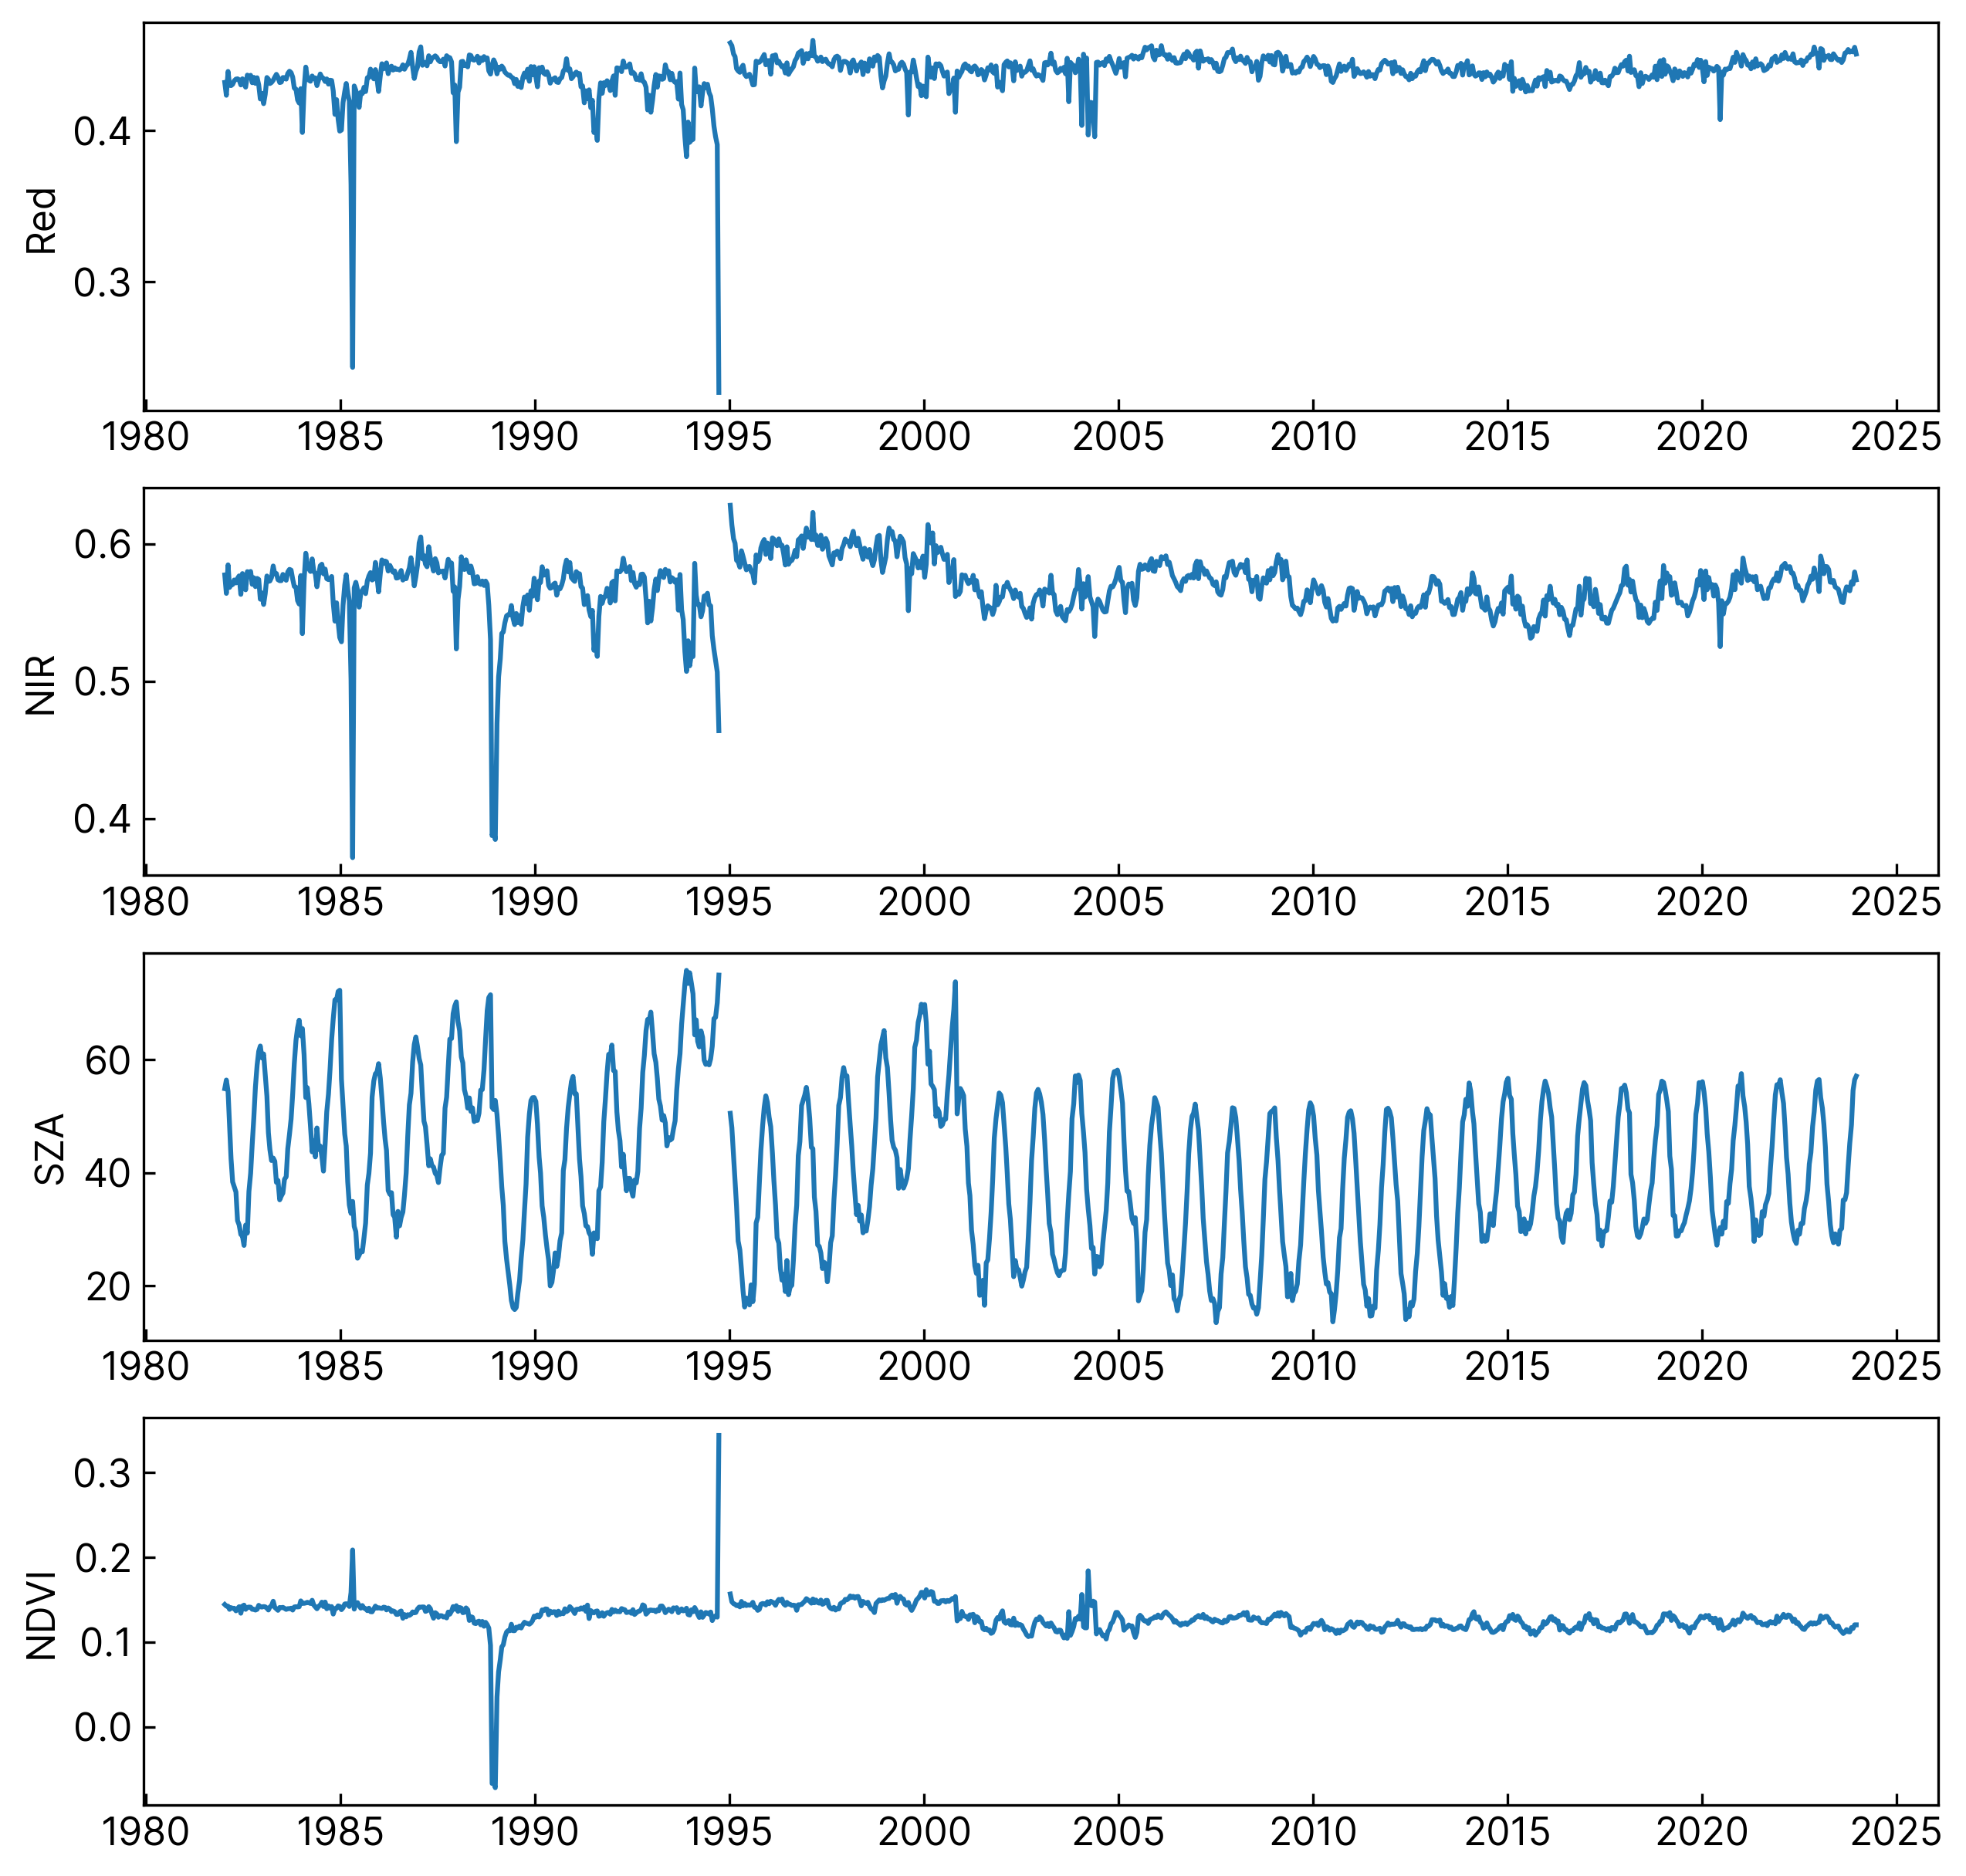

In [15]:
fig, axs = plt.subplots(4,1, figsize=(10, 10), dpi=300)
ax = axs.flatten()
nir_mean =  np.nanmean(nir_pics[:, cal_idx], axis=1)
red_mean =  np.nanmean(red_pics[:, cal_idx], axis=1)
sza_mean =  np.nanmean(sza_pics[:, cal_idx], axis=1)
ndvi_mean = (nir_mean - red_mean) / (nir_mean + red_mean)
ax[0].plot(time_list, red_mean)
ax[0].set_ylabel("Red")
ax[1].plot(time_list, nir_mean)
ax[1].set_ylabel("NIR")
ax[2].plot(time_list, sza_mean)
ax[2].set_ylabel("SZA")
ax[3].plot(time_list, (nir_mean - red_mean) / (nir_mean + red_mean))
ax[3].set_ylabel("NDVI")
plt.show()

In [16]:
time_arr = np.array(time_list)
print("time that nir_pics < 0.5")
print(time_arr[np.nanmean(nir_pics[:, cal_idx], axis=1) < 0.5])
print("time that red_pics < 0.35")
print(time_arr[np.nanmean(red_pics[:, cal_idx], axis=1) < 0.35])

time that nir_pics < 0.5
['1985-04-23T00:00:00.000000000' '1988-11-23T00:00:00.000000000'
 '1988-12-08T00:00:00.000000000' '1988-12-23T00:00:00.000000000'
 '1989-01-08T00:00:00.000000000' '1994-09-23T00:00:00.000000000']
time that red_pics < 0.35
['1985-04-23T00:00:00.000000000' '1994-09-23T00:00:00.000000000']


We remove 198811a-198910b as the bad period previously reported, as well as periods where observations are missing 199409b-199422b

In [17]:
valid_period = np.full(len(time_arr), True)
valid_period[164:188] = False
valid_period[305:312] = False
valid_period[79] = False

In [18]:
red_copy = deepcopy(red_mean)
red_copy[np.invert(valid_period)] = np.nan

nir_copy = deepcopy(nir_mean)
nir_copy[np.invert(valid_period)] = np.nan

ndvi_copy = deepcopy(ndvi_mean)
ndvi_copy[np.invert(valid_period)] = np.nan

red_avhrr2 = red_copy[:452]
red_avhrr3 = red_copy[452:]
red_avhrr2_mean = np.full(len(red_avhrr2), np.nanmean(red_avhrr2))
red_avhrr3_mean = np.full(len(red_avhrr3), np.nanmean(red_avhrr3))


nir_avhrr2 = nir_copy[:452]
nir_avhrr3 = nir_copy[452:]
nir_avhrr2_mean = np.full(len(nir_avhrr2), np.nanmean(nir_avhrr2))
nir_avhrr3_mean = np.full(len(nir_avhrr3), np.nanmean(nir_avhrr3))

time_avhrr2 = time_arr[:452]
time_avhrr3 = time_arr[452:]



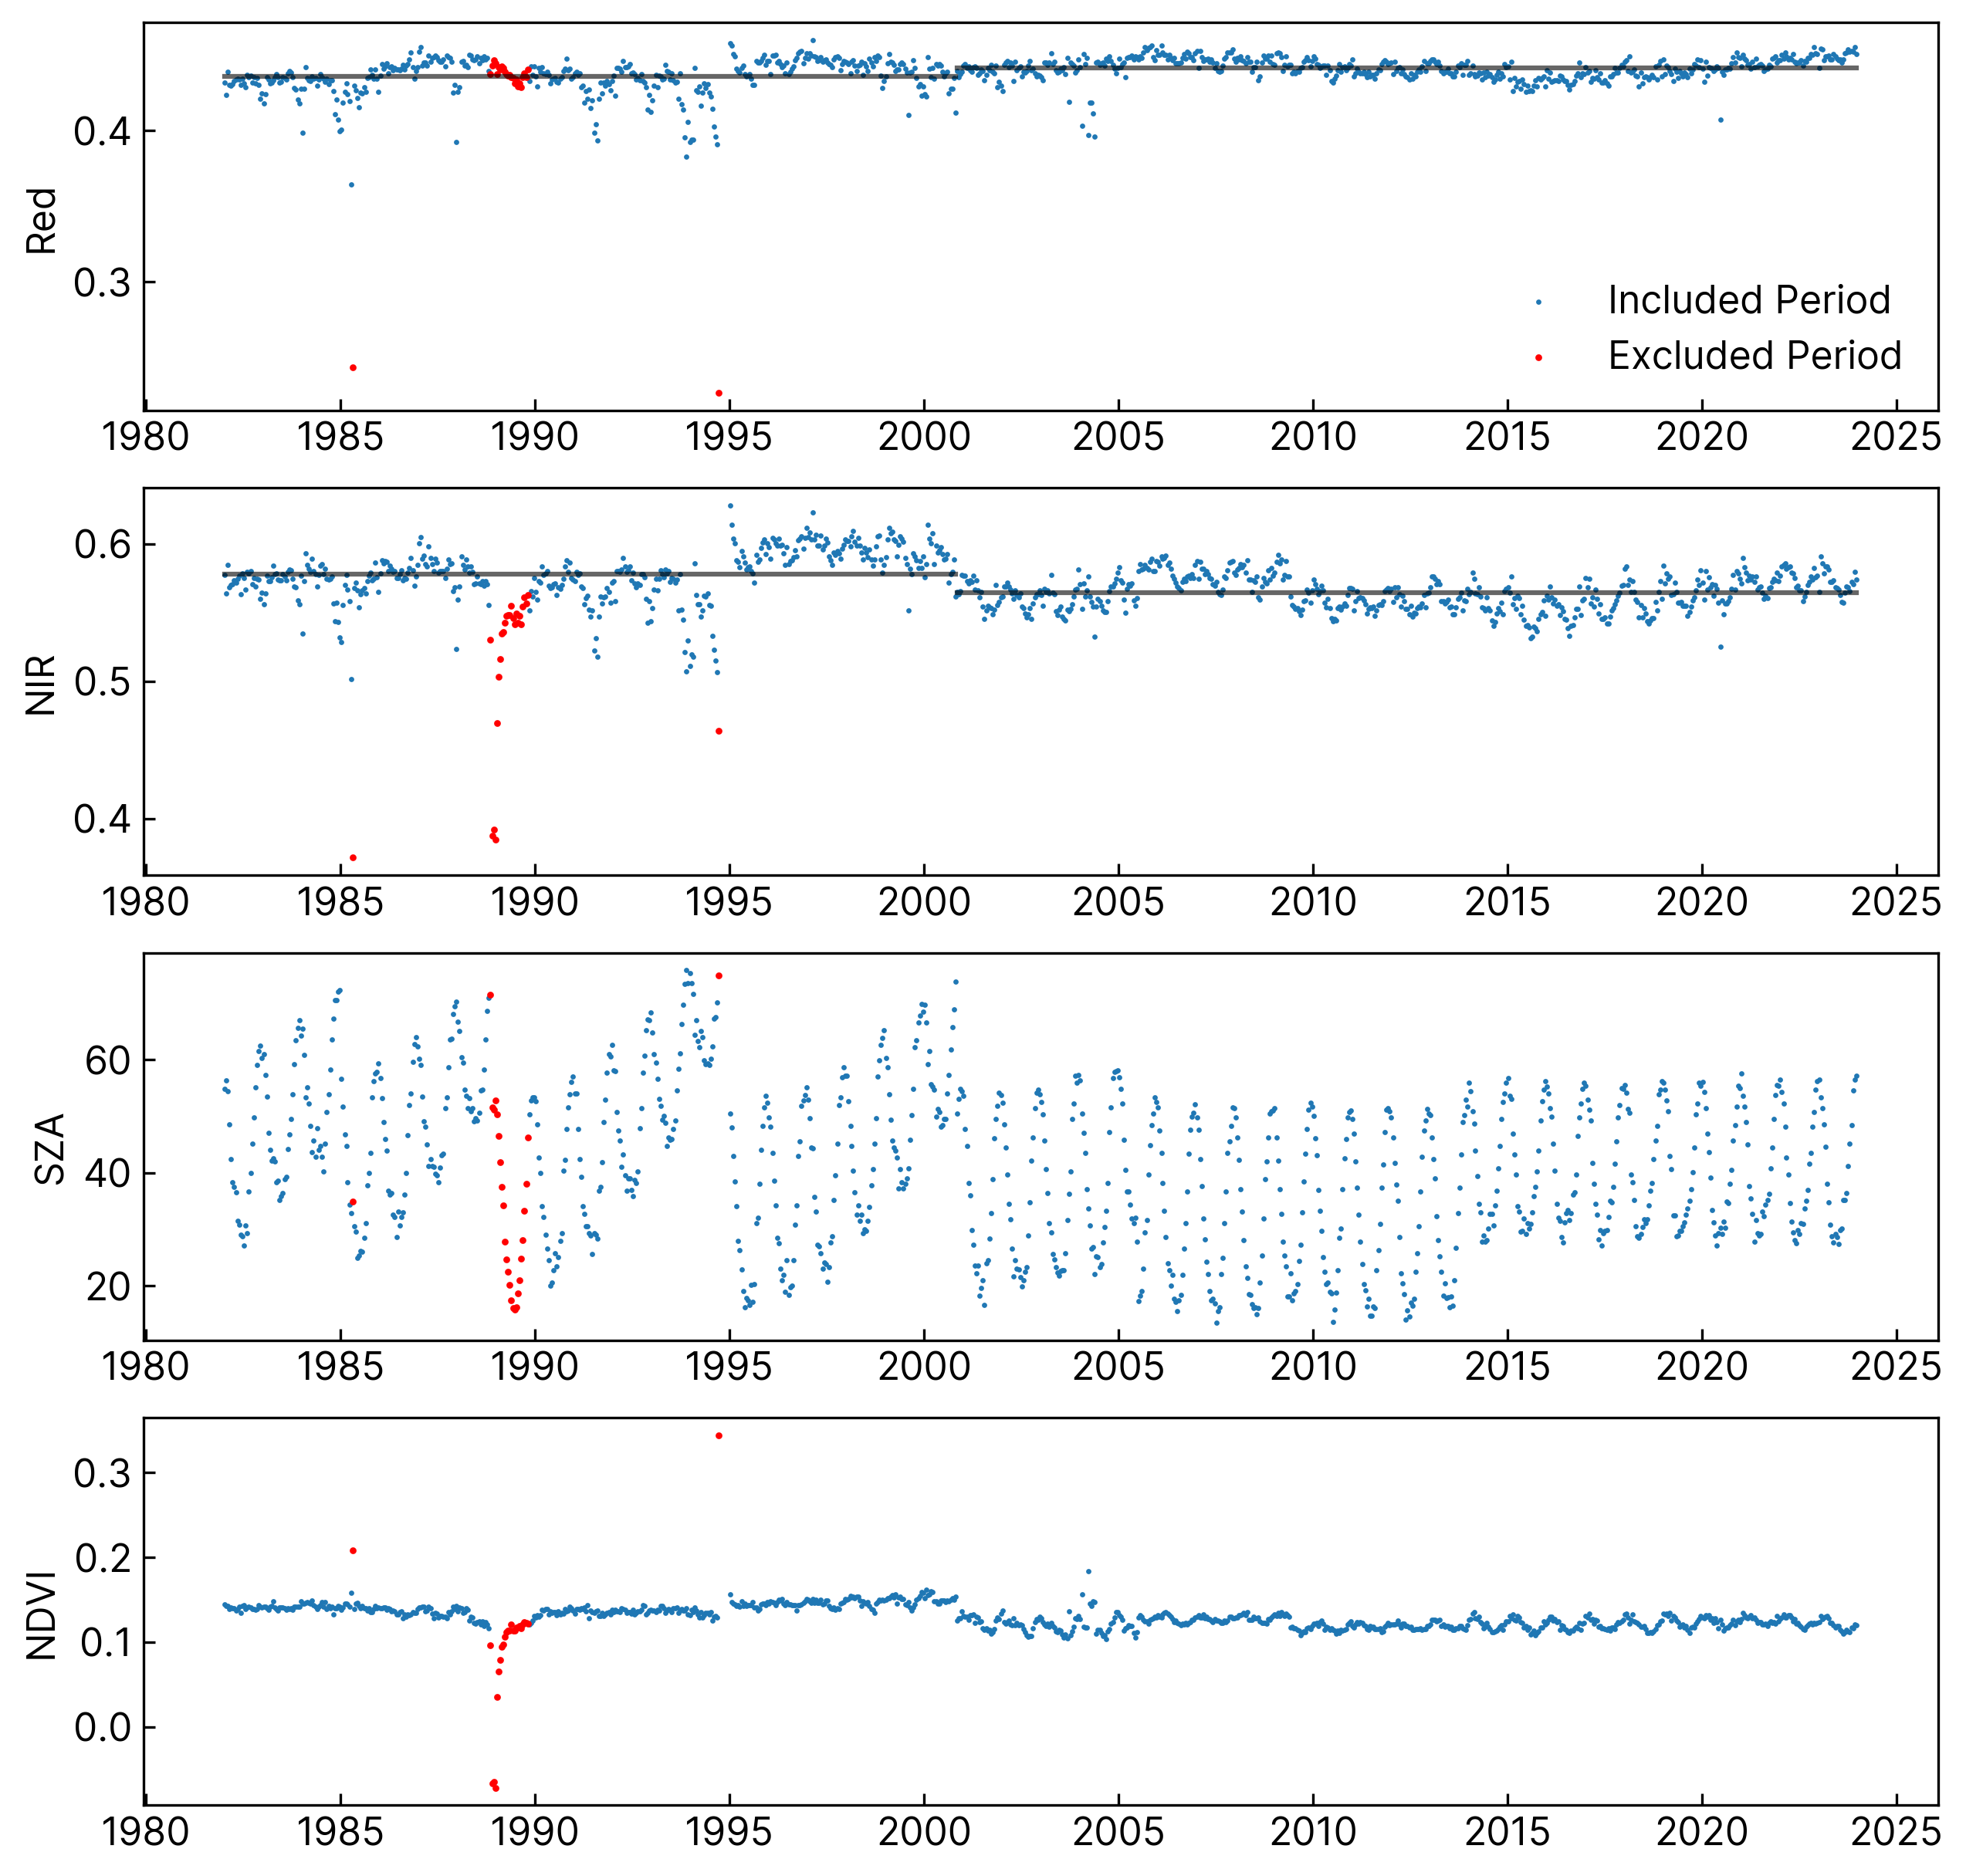

In [19]:
fig, axs = plt.subplots(4,1, figsize=(10, 10), dpi=300)
ax = axs.flatten()
nir_mean =  np.nanmean(nir_pics[:, cal_idx], axis=1)
red_mean =  np.nanmean(red_pics[:, cal_idx], axis=1)
sza_mean =  np.nanmean(sza_pics[:, cal_idx], axis=1)
ndvi = (nir_mean - red_mean) / (nir_mean + red_mean)

ax[0].plot(time_avhrr2, red_avhrr2_mean, c="k", alpha=0.6)
ax[0].plot(time_avhrr3, red_avhrr3_mean, c="k", alpha=0.6)

ax[0].scatter(time_arr[valid_period], red_mean[valid_period], s=0.4, label="Included Period")
ax[0].scatter(time_arr[np.invert(valid_period)], red_mean[np.invert(valid_period)], s=1.2, c="red", label="Excluded Period")
ax[0].set_ylabel("Red")
ax[0].legend(frameon=False)

ax[1].plot(time_avhrr2, nir_avhrr2_mean, c="k", alpha=0.6)
ax[1].plot(time_avhrr3, nir_avhrr3_mean, c="k", alpha=0.6)
ax[1].scatter(time_arr[valid_period], nir_mean[valid_period], s=0.4)
ax[1].scatter(time_arr[np.invert(valid_period)], nir_mean[np.invert(valid_period)],  s=1.2, c="red", )
ax[1].set_ylabel("NIR")

ax[2].scatter(time_arr[valid_period], sza_mean[valid_period], s=0.4)
ax[2].scatter(time_arr[np.invert(valid_period)], sza_mean[np.invert(valid_period)],  s=1.2, c="red", )
ax[2].set_ylabel("SZA")
ax[3].scatter(time_arr[valid_period], ndvi[valid_period], s=0.4)
ax[3].scatter(time_arr[np.invert(valid_period)], ndvi[np.invert(valid_period)],  s=1.2, c="red", )
ax[3].set_ylabel("NDVI")
plt.show()

In [20]:
np.save("time_arr.npy", time_arr)
np.save("nir_pics.npy", nir_pics)
np.save("red_pics.npy", red_pics)
np.save("sza_pics.npy", sza_pics)
np.save("pics_cal_red_mean.npy", red_mean)
np.save("pics_cal_nir_mean.npy", nir_mean)
np.save("pics_cal_sza_mean.npy", sza_mean)
np.save("valid_period.npy", valid_period)

In [93]:
time_arr = np.load("time_arr.npy")
nir_pics = np.load("nir_pics.npy")
red_pics = np.load("red_pics.npy")
sza_pics = np.load("sza_pics.npy")
red_mean = np.load("pics_cal_red_mean.npy")
nir_mean = np.load("pics_cal_nir_mean.npy")
sza_mean = np.load("pics_cal_sza_mean.npy")
valid_period = np.load("valid_period.npy")
cal_idx = np.load("pics_cal_idx.npy")

In [32]:
red_pics_m1= deepcopy(red_pics[-24*10:, :][:, cal_idx])
nir_pics_m1= deepcopy(nir_pics[-24*10:, :][:, cal_idx])


red_pics_avhrr= deepcopy(red_pics[:-24*10, :][:, cal_idx])
nir_pics_avhrr= deepcopy(nir_pics[:-24*10, :][:, cal_idx])

red_pics_avhrr_scaled = np.full(red_pics_avhrr.shape, np.nan)
nir_pics_avhrr_scaled = np.full(nir_pics_avhrr.shape, np.nan)



for i in range(len(cal_idx)):
    red_low = np.percentile(red_pics_m1[:, i], 1)
    red_high = np.percentile(red_pics_m1[:, i], 99)
    red_m1_smooth = deepcopy(red_pics_m1[:, i])
    red_m1_smooth[(red_m1_smooth < red_low) | (red_m1_smooth > red_high)] = np.nan
    red_pics_avhrr_scaled[:, i] = red_pics_avhrr[:, i] - np.tile(np.nanmean(red_m1_smooth.reshape(-1, 24), axis=0), red_pics_avhrr.shape[0] // 24)
    nir_low = np.percentile(nir_pics_m1[:, i], 1)
    nir_high = np.percentile(nir_pics_m1[:, i], 99)
    nir_m1_smooth = deepcopy(nir_pics_m1[:, i])
    nir_m1_smooth[(nir_m1_smooth < nir_low) | (nir_m1_smooth > nir_high)] = np.nan
    nir_pics_avhrr_scaled[:, i] = nir_pics_avhrr[:, i] - np.tile(np.nanmean(nir_m1_smooth.reshape(-1, 24), axis=0), nir_pics_avhrr.shape[0] // 24)

In [33]:
nir_pics_avhrr_scaled_cal_mean = np.nanmean(nir_pics_avhrr_scaled, axis=1)
red_pics_avhrr_scaled_cal_mean = np.nanmean(red_pics_avhrr_scaled, axis=1)
time_arr_avhrr = time_arr[:-24*10]
valid_period_avhrr = valid_period[:-24*10]

In [34]:
np.save("../../data/nir_pics_avhrr_scaled_cal_mean.npy", nir_pics_avhrr_scaled_cal_mean)
np.save("../../data/red_pics_avhrr_scaled_cal_mean.npy", red_pics_avhrr_scaled_cal_mean)
np.save("../../data/valid_period_avhrr.npy", valid_period_avhrr)
np.save("../../data/time_arr_avhrr.npy", time_arr_avhrr)

In [35]:
nir_pics_avhrr_scaled_cal_mean = np.load("../../data/nir_pics_avhrr_scaled_cal_mean.npy")
red_pics_avhrr_scaled_cal_mean = np.load("../../data/red_pics_avhrr_scaled_cal_mean.npy")
valid_period_avhrr = np.load("../../data/valid_period_avhrr.npy")
time_arr_avhrr = np.load("../../data/time_arr_avhrr.npy")


In [36]:
linregress(np.arange(len(nir_pics_avhrr_scaled_cal_mean))[valid_period_avhrr], nir_pics_avhrr_scaled_cal_mean[valid_period_avhrr])

LinregressResult(slope=-1.2921605390756648e-05, intercept=0.015075872078011383, rvalue=-0.16484788647384416, pvalue=6.943954447978708e-06, stderr=2.853661532900399e-06, intercept_stderr=0.0012852220463260213)

In [38]:
linregress(np.arange(len(red_pics_avhrr_scaled_cal_mean))[valid_period_avhrr], red_pics_avhrr_scaled_cal_mean[valid_period_avhrr])

LinregressResult(slope=1.6855458676005604e-05, intercept=-0.008425188220101115, rvalue=0.33320307566938645, pvalue=1.528352384706663e-20, stderr=1.7604694421169105e-06, intercept_stderr=0.0007928740366739547)

In [17]:
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

MODIS_LCSPP_DIR="AVHRR/data/MODIS_LCSPP_v3"
MODIS_LCREF_DIR="AVHRR/data/MODIS_LCREF_v3"
LCSPP_v32_DIR="AVHRR/data/LCSPP_v3.2/"
LCREF_v32_DIR="AVHRR/data/LCREF_v3.2/"
LTDR_LCSPP = "AVHRR/data/LTDR_LCSPP/"
LTDR_LCREF = "AVHRR/data/LTDR_LCREF/"


LCSPP_v32_LIST=[f for f in get_file_list(LCSPP_v32_DIR)]
LCREF_v32_LIST=[f for f in get_file_list(LCREF_v32_DIR)]
LTDR_LCSPP_LIST = get_file_list(LTDR_LCSPP)
LTDR_LCREF_LIST = get_file_list(LTDR_LCREF)


MODIS_LCSPP_FILE_LIST=get_file_list(MODIS_LCSPP_DIR)
MODIS_LCREF_FILE_LIST=get_file_list(MODIS_LCREF_DIR)

LCSPP_v32_PRE_2001_PERIOD_FILE_LIST=LCSPP_v32_LIST[0:19*24]
LCSPP_v32_POST_2001_PERIOD_FILE_LIST=LCSPP_v32_LIST[19*24:]

LCREF_v32_PRE_2001_PERIOD_FILE_LIST=LCREF_v32_LIST[0:19*24]
LCREF_v32_POST_2001_PERIOD_FILE_LIST=LCREF_v32_LIST[19*24:]


LTDR_LCSPP_PRE_2001_PERIOD_FILE_LIST=LTDR_LCSPP_LIST[0:19*24]
LTDR_LCSPP_POST_2001_PERIOD_FILE_LIST=LTDR_LCSPP_LIST[19*24:]



def extract_nir_pics_df_site(file_list):
    pics_df_nir_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).nir
        pics_df_nir_list.append(np.diag(ds.sel(lat=pics_df.lat.values, lon=pics_df.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_df_nir_list

def extract_red_pics_df_site(file_list):
    pics_df_red_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).red
        pics_df_red_list.append(np.diag(ds.sel(lat=pics_df.lat.values, lon=pics_df.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_df_red_list

def extract_lcspp_pics_df_site(file_list):
    pics_df_lcspp_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).lcspp_clear_daily
        pics_df_lcspp_list.append(np.diag(ds.sel(lat=pics_df.lat.values, lon=pics_df.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_df_lcspp_list

RED_AVHRR = extract_red_pics_df_site(LCREF_v32_LIST)
RED_MODIS = extract_red_pics_df_site(MODIS_LCREF_FILE_LIST)
RED_LTDR = extract_red_pics_df_site(LTDR_LCREF_LIST)

NIR_AVHRR = extract_nir_pics_df_site(LCREF_v32_LIST)
NIR_MODIS = extract_nir_pics_df_site(MODIS_LCREF_FILE_LIST)
NIR_LTDR = extract_nir_pics_df_site(LTDR_LCREF_LIST)

LCSPP_AVHRR= extract_lcspp_pics_df_site(LCSPP_v32_LIST)
LCSPP_MODIS = extract_lcspp_pics_df_site(MODIS_LCSPP_FILE_LIST)
LCSPP_LTDR = extract_lcspp_pics_df_site(LTDR_LCSPP_LIST)

RED_AVHRR_MATRIX = np.vstack(RED_AVHRR)
RED_MODIS_MATRIX = np.vstack(RED_MODIS)
RED_LTDR_MATRIX = np.vstack(RED_LTDR)

NIR_AVHRR_MATRIX = np.vstack(NIR_AVHRR)
NIR_MODIS_MATRIX = np.vstack(NIR_MODIS)
NIR_LTDR = np.vstack(NIR_LTDR)

LCSPP_AVHRR_MATRIX = np.vstack(LCSPP_AVHRR)
LCSPP_MODIS_MATRIX = np.vstack(LCSPP_MODIS)
LCSPP_LTDR_MATRIX = np.vstack(LCSPP_MODIS)


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [26]:
np.save("RED_AVHRR_MATRIX.npy", RED_AVHRR_MATRIX)
np.save("RED_MODIS_MATRIX.npy", RED_MODIS_MATRIX)
np.save("RED_LTDR_MATRIX.npy", RED_LTDR_MATRIX)

np.save("NIR_AVHRR_MATRIX.npy", NIR_AVHRR_MATRIX)
np.save("NIR_MODIS_MATRIX.npy", NIR_MODIS_MATRIX)
np.save("NIR_LTDR_MATRIX.npy", NIR_LTDR)

np.save("LCSPP_AVHRR_MATRIX.npy", LCSPP_AVHRR_MATRIX)
np.save("LCSPP_MODIS_MATRIX.npy", LCSPP_MODIS_MATRIX)
np.save("LCSPP_LTDR_MATRIX.npy", LCSPP_LTDR_MATRIX)

In [42]:
SZA_PATH = "AVHRR/data/AVHRR_SZA_CORRECTED_v3.2/"
sza_files = sorted([f for f in os.listdir(SZA_PATH) if "temp" not in f])
pics_df = pd.read_csv("PICS.csv")

time_arr = np.load("time_arr.npy")
valid_period = np.load("valid_period.npy")
time_arr_valid = time_arr[valid_period]

biweekly_identifiers = []
for month in np.arange(1, 13):
    for half_month_index in ["a", "b"]:
        biweekly_identifiers.append('{:0>2}'.format(month) + half_month_index)
        
# Obtain the filenames for all the input datasets
MVC_files = []
for year in np.arange(1982, 2024):
    mr = np.arange(1, 13)
    
    for month in mr:
        for half_month_index in ["a", "b"]:
            MVC_files.append(os.path.join(MVC_DIR, "AVHRR_MVC_" + str(year) + '{:0>2}'.format(month) + half_month_index + ".nc"))
            
MVC_files_valid  = np.array(MVC_files)[valid_period][:-10*24]
MVC_files_valid_all  = np.array(MVC_files)[valid_period]

mvc_idx = []
for bi in biweekly_identifiers:
    bi_list = []
    for i in range(len(MVC_files_valid)):
        if bi in MVC_files_valid[i]:
            bi_list.append(i)
    mvc_idx.append(bi_list)
    
mvc_idx_all = []
for bi in biweekly_identifiers:
    bi_list = []
    for i in range(len(MVC_files_valid_all)):
        if bi in MVC_files_valid_all[i]:
            bi_list.append(i)
    mvc_idx_all.append(bi_list)


In [43]:
red_sza_pics = np.zeros((len(MVC_files_valid), 20)).astype(np.float32)
nir_sza_pics = np.zeros((len(MVC_files_valid), 20)).astype(np.float32)

for hm in range(24):
    for j in range(len(pics_df.index)):
        sza_array = np.load(os.path.join(SZA_PATH, sza_files[hm]))
        sza_ds = xr.DataArray(sza_array, coords={"time":np.arange(sza_array.shape[0]),
                                                                          "lat":np.flip(np.arange(-59.975, 90, 0.05)), 
                                                                          "lon":np.arange(-179.975, 180, 0.05)})
        lat_idx = np.argmin(np.abs(sza_ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(sza_ds.lon.values - pics_df.lon[j]))
        nir_sza_pics[mvc_idx[hm], j] = np.nanmean(sza_ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.reshape(len(sza_ds.time), -1), axis=1)
for hm in range(24):
    for j in range(len(pics_df.index)):
        sza_array = np.load(os.path.join(SZA_PATH, sza_files[hm+24]))
        sza_ds = xr.DataArray(sza_array, coords={"time":np.arange(sza_array.shape[0]),
                                                                          "lat":np.flip(np.arange(-59.975, 90, 0.05)), 
                                                                          "lon":np.arange(-179.975, 180, 0.05)})
        lat_idx = np.argmin(np.abs(sza_ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(sza_ds.lon.values - pics_df.lon[j]))
        red_sza_pics[mvc_idx[hm], j] = np.nanmean(sza_ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.reshape(len(sza_ds.time), -1), axis=1) 


In [51]:
LINEAR_PATH = "AVHRR/data/AVHRR_LINEAR_CORRECTED_v3.2/"
linear_files = sorted([f for f in os.listdir(LINEAR_PATH) if "corrected" in f])

red_linear_pics = np.zeros((len(MVC_files_valid_all), 20)).astype(np.float32)
nir_linear_pics = np.zeros((len(MVC_files_valid_all), 20)).astype(np.float32)
for hm in range(24):
    for j in range(len(pics_df.index)):
        linear_array = np.load(os.path.join(LINEAR_PATH, linear_files[hm]))
        linear_ds = xr.DataArray(linear_array, coords={"time":np.arange(linear_array.shape[0]),
                                                                          "lat":np.flip(np.arange(-59.975, 90, 0.05)), 
                                                                          "lon":np.arange(-179.975, 180, 0.05)})
        lat_idx = np.argmin(np.abs(linear_ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(linear_ds.lon.values - pics_df.lon[j]))
        nir_linear_pics[mvc_idx_all[hm], j] = np.nanmean(linear_ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.reshape(len(linear_ds.time), -1), axis=1)
for hm in range(24):
    for j in range(len(pics_df.index)):
        linear_array = np.load(os.path.join(LINEAR_PATH, linear_files[hm+24]))
        linear_ds = xr.DataArray(linear_array, coords={"time":np.arange(linear_array.shape[0]),
                                                                          "lat":np.flip(np.arange(-59.975, 90, 0.05)), 
                                                                          "lon":np.arange(-179.975, 180, 0.05)})
        lat_idx = np.argmin(np.abs(linear_ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(linear_ds.lon.values - pics_df.lon[j]))
        red_linear_pics[mvc_idx_all[hm], j] = np.nanmean(linear_ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3].values.reshape(len(linear_ds.time), -1), axis=1)

def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist
LCSPP_v32_DIR="AVHRR/data/LCSPP_v3.2/"
LCREF_v32_DIR="AVHRR/data/LCREF_v3.2/"
LCSPP_v32_LIST=[f for f in get_file_list(LCSPP_v32_DIR)]
LCREF_v32_LIST=[f for f in get_file_list(LCREF_v32_DIR)]

red_lcref_pics = np.zeros((len(LCREF_v32_LIST), 20)).astype(np.float32)
nir_lcref_pics = np.zeros((len(LCREF_v32_LIST), 20)).astype(np.float32)
lcspp_pics = np.zeros((len(LCSPP_v32_LIST), 20)).astype(np.float32)

for i in range(len(LCREF_v32_LIST)):
    ds=xr.open_dataset(LCREF_v32_LIST[i]).red
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        red_lcref_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])
        
for i in range(len(LCREF_v32_LIST)):
    ds=xr.open_dataset(LCREF_v32_LIST[i]).nir
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        nir_lcref_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])
        
for i in range(len(LCSPP_v32_LIST)):
    ds=xr.open_dataset(LCSPP_v32_LIST[i]).lcspp_clear_daily
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        lcspp_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])  

In [52]:
N07_idx = (0, 72)
N09_idx = (72, 164)
N11_idx = (164, 312)
N14_idx = (312, 452)
N16_idx = (452, 564)
N18_idx = (564, 658)
N19_idx =(658, 768)
M1_idx = (768, 984)

pics_df = pd.read_csv("PICS.csv")
cal_idx = np.load("pics_cal_idx.npy")
val_idx = np.load("pics_val_idx.npy")

In [53]:
red_lcref_pics_msc = np.mean(red_lcref_pics.reshape(42, 24,20), axis=0)
red_lcref_pics_msc_tile =  np.tile(red_lcref_pics_msc.T, 42).T
red_lcref_pics_deseason = red_lcref_pics - red_lcref_pics_msc_tile

nir_lcref_pics_msc = np.mean(nir_lcref_pics.reshape(42, 24,20), axis=0)
nir_lcref_pics_msc_tile =  np.tile(nir_lcref_pics_msc.T, 42).T
nir_lcref_pics_deseason = nir_lcref_pics - nir_lcref_pics_msc_tile

nir_pics = np.load("nir_pics.npy")
red_pics = np.load("red_pics.npy")

In [95]:
nir_pics = np.load("nir_pics.npy")
red_pics = np.load("red_pics.npy")
nir_pics[valid_period==False]=(nir_pics[np.arange(len(valid_period))[valid_period==False]-24]+nir_pics[np.arange(len(valid_period))[valid_period==False]+24])/2
red_pics[valid_period==False]=(red_pics[np.arange(len(valid_period))[valid_period==False]-24]+red_pics[np.arange(len(valid_period))[valid_period==False]+24])/2

In [55]:
red_lcref_pics_msc = np.mean(red_lcref_pics.reshape(42, 24,20), axis=0)
red_lcref_pics_msc_tile =  np.tile(red_lcref_pics_msc.T, 42).T
red_lcref_pics_deseason = red_lcref_pics - red_lcref_pics_msc_tile

nir_lcref_pics_msc = np.mean(nir_lcref_pics.reshape(42, 24,20), axis=0)
nir_lcref_pics_msc_tile =  np.tile(nir_lcref_pics_msc.T, 42).T
nir_lcref_pics_deseason = nir_lcref_pics - nir_lcref_pics_msc_tile

red_pics_msc = np.mean(red_pics.reshape(42, 24,20), axis=0)
red_pics_msc_tile =  np.tile(red_pics_msc.T, 42).T
red_pics_deseason = red_pics - red_pics_msc_tile

nir_pics_msc = np.mean(nir_pics.reshape(42, 24,20), axis=0)
nir_pics_msc_tile =  np.tile(nir_pics_msc.T, 42).T
nir_pics_deseason = nir_pics - nir_pics_msc_tile

In [56]:
red_pics_msc = np.mean(red_pics.reshape(42, 24,20), axis=0)
red_pics_msc_tile =  np.tile(red_pics_msc.T, 42).T
red_pics_deseason = red_pics - red_pics_msc_tile

nir_pics_msc = np.mean(nir_pics.reshape(42, 24,20), axis=0)
nir_pics_msc_tile =  np.tile(nir_pics_msc.T, 42).T
nir_pics_deseason = nir_pics - nir_pics_msc_tile

In [57]:
N07_idx = (0, 72)
N09_idx = (72, 164)
N11_idx = (164, 312)
N14_idx = (312, 452)
N16_idx = (452, 564)
N18_idx = (564, 658)
N19_idx =(658, 768)
M1_idx = (768, 984)

In [67]:
def get_mean_and_std_difference(variable, sat_idx, val_idx, split_name, varname):
    variable_msc = np.mean(variable.reshape(42, 24,20), axis=0)
    variable_msc_tile =  np.tile(variable_msc.T, 42).T
    variable_deseason = variable - variable_msc_tile
    percent_diff = np.mean(variable_deseason[sat_idx[1]:sat_idx[1]+24, val_idx] - variable_deseason[sat_idx[1]-24:sat_idx[1], val_idx], axis=0)/np.mean(variable[:, val_idx], axis=0)*100
    return {"split_name": split_name,
            "varname":varname,
            "mean":np.mean(percent_diff), 
            "std":np.std(percent_diff)}

def get_mean_and_std_difference_modis(variable, i, val_idx, varname):
    variable_msc = np.mean(variable.reshape(23, 24,20), axis=0)
    variable_msc_tile =  np.tile(variable_msc.T, 23).T
    variable_deseason = variable - variable_msc_tile
    percent_diff = np.mean(variable_deseason[(i+1)*24:(i+2)*24, val_idx] - variable_deseason[(i)*24:(i+1)*24, val_idx], axis=0)/np.mean(variable[:, val_idx], axis=0)*100
    return {"split_name": i,
            "varname":varname,
            "mean":np.mean(percent_diff), 
            "std":np.std(percent_diff)}




def get_split_diff(variable, sat_idx, val_idx, split_name, varname):
    variable_msc = np.mean(variable.reshape(42, 24,20), axis=0)
    variable_msc_tile =  np.tile(variable_msc.T, 42).T
    variable_deseason = variable - variable_msc_tile
    percent_diff = np.mean(variable_deseason[sat_idx[1]:sat_idx[1]+24, val_idx] - variable_deseason[sat_idx[1]-24:sat_idx[1], val_idx], axis=0)/np.mean(variable[:, val_idx], axis=0)*100
    return {"split_name": split_name,
            "varname":varname,
            "diff":percent_diff}


In [68]:
split_stat=[]

split_stat.append(get_mean_and_std_difference(red_pics, N07_idx, val_idx, "N09-N07", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N09_idx, val_idx, "N11-N09", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N11_idx, val_idx, "N14-N11", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N14_idx, val_idx, "N16-N14", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N16_idx, val_idx, "N18-N16", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N18_idx, val_idx, "N19-N18", "RED_LTDR"))
split_stat.append(get_mean_and_std_difference(red_pics, N19_idx, val_idx, "M1-N19", "RED_LTDR"))

split_stat.append(get_mean_and_std_difference(nir_pics, N07_idx, val_idx, "N09-N07", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N09_idx, val_idx, "N11-N09", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N11_idx, val_idx, "N14-N11", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N14_idx, val_idx, "N16-N14", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N16_idx, val_idx, "N18-N16", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N18_idx, val_idx, "N19-N18", "NIR_LTDR"))
split_stat.append(get_mean_and_std_difference(nir_pics, N19_idx, val_idx, "M1-N19", "NIR_LTDR"))

split_stat.append(get_mean_and_std_difference(red_lcref_pics, N07_idx, val_idx, "N09-N07", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N09_idx, val_idx, "N11-N09", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N11_idx, val_idx, "N14-N11", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N14_idx, val_idx, "N16-N14", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N16_idx, val_idx, "N18-N16", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N18_idx, val_idx, "N19-N18", "RED_LCREF"))
split_stat.append(get_mean_and_std_difference(red_lcref_pics, N19_idx, val_idx, "M1-N19", "RED_LCREF"))

split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N07_idx, val_idx, "N09-N07", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N09_idx, val_idx, "N11-N09", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N11_idx, val_idx, "N14-N11", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N14_idx, val_idx, "N16-N14", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N16_idx, val_idx, "N18-N16", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N18_idx, val_idx, "N19-N18", "NIR_LCREF"))
split_stat.append(get_mean_and_std_difference(nir_lcref_pics, N19_idx, val_idx, "M1-N19", "NIR_LCREF"))

In [69]:
split_diff=[]

split_diff.append(get_split_diff(red_pics, N07_idx, val_idx, "N09-N07", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N09_idx, val_idx, "N11-N09", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N11_idx, val_idx, "N14-N11", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N14_idx, val_idx, "N16-N14", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N16_idx, val_idx, "N18-N16", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N18_idx, val_idx, "N19-N18", "RED_LTDR"))
split_diff.append(get_split_diff(red_pics, N19_idx, val_idx, "M1-N19", "RED_LTDR"))

split_diff.append(get_split_diff(nir_pics, N07_idx, val_idx, "N09-N07", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N09_idx, val_idx, "N11-N09", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N11_idx, val_idx, "N14-N11", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N14_idx, val_idx, "N16-N14", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N16_idx, val_idx, "N18-N16", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N18_idx, val_idx, "N19-N18", "NIR_LTDR"))
split_diff.append(get_split_diff(nir_pics, N19_idx, val_idx, "M1-N19", "NIR_LTDR"))

split_diff.append(get_split_diff(red_lcref_pics, N07_idx, val_idx, "N09-N07", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N09_idx, val_idx, "N11-N09", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N11_idx, val_idx, "N14-N11", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N14_idx, val_idx, "N16-N14", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N16_idx, val_idx, "N18-N16", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N18_idx, val_idx, "N19-N18", "RED_LCREF"))
split_diff.append(get_split_diff(red_lcref_pics, N19_idx, val_idx, "M1-N19", "RED_LCREF"))

split_diff.append(get_split_diff(nir_lcref_pics, N07_idx, val_idx, "N09-N07", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N09_idx, val_idx, "N11-N09", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N11_idx, val_idx, "N14-N11", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N14_idx, val_idx, "N16-N14", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N16_idx, val_idx, "N18-N16", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N18_idx, val_idx, "N19-N18", "NIR_LCREF"))
split_diff.append(get_split_diff(nir_lcref_pics, N19_idx, val_idx, "M1-N19", "NIR_LCREF"))

In [83]:
split_df = pd.DataFrame(split_stat)
split_diff_df = pd.DataFrame(split_diff)

In [63]:
MODIS_LCSPP_DIR="AVHRR/data/MODIS_LCSPP_v3"
MODIS_LCREF_DIR="AVHRR/data/MODIS_LCREF_v3"
MODIS_LCSPP_FILE_LIST=[f for f in get_file_list(MODIS_LCSPP_DIR)]
MODIS_LCREF_FILE_LIST=[f for f in get_file_list(MODIS_LCREF_DIR)]

modis_red_lcref_pics = np.zeros((len(MODIS_LCREF_FILE_LIST), 20)).astype(np.float32)
modis_nir_lcref_pics = np.zeros((len(MODIS_LCREF_FILE_LIST), 20)).astype(np.float32)
modis_lcspp_pics = np.zeros((len(MODIS_LCSPP_FILE_LIST), 20)).astype(np.float32)


for i in range(len(MODIS_LCREF_FILE_LIST)):
    ds=xr.open_dataset(MODIS_LCREF_FILE_LIST[i]).red
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        modis_red_lcref_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])
        
for i in range(len(MODIS_LCREF_FILE_LIST)):
    ds=xr.open_dataset(MODIS_LCREF_FILE_LIST[i]).nir
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        modis_nir_lcref_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])
        
for i in range(len(MODIS_LCSPP_FILE_LIST)):
    ds=xr.open_dataset(MODIS_LCSPP_FILE_LIST[i]).lcspp_clear_daily
    for j in range(len(pics_df.index)):
        lat_idx = np.argmin(np.abs(ds.lat.values - pics_df.lat[j]))
        lon_idx = np.argmin(np.abs(ds.lon.values - pics_df.lon[j]))
        modis_lcspp_pics[i, j] = np.nanmean(ds[:, lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3])       
        

In [72]:
for i in range (0, 22):
    print(get_mean_and_std_difference_modis(modis_red_lcref_pics, i, val_idx, "RED_MODIS"))
    
for i in range (0, 22):
    print(get_mean_and_std_difference_modis(modis_nir_lcref_pics, i, val_idx, "NIR_MODIS"))

{'split_name': 0, 'varname': 'RED_MODIS', 'mean': 0.28066596, 'std': 0.30192992}
{'split_name': 1, 'varname': 'RED_MODIS', 'mean': -0.10075583, 'std': 0.67923975}
{'split_name': 2, 'varname': 'RED_MODIS', 'mean': -0.28516096, 'std': 0.5401781}
{'split_name': 3, 'varname': 'RED_MODIS', 'mean': -0.091913484, 'std': 0.31162822}
{'split_name': 4, 'varname': 'RED_MODIS', 'mean': -0.13119297, 'std': 0.38060653}
{'split_name': 5, 'varname': 'RED_MODIS', 'mean': 0.29197395, 'std': 0.20143348}
{'split_name': 6, 'varname': 'RED_MODIS', 'mean': 0.33555, 'std': 0.31962454}
{'split_name': 7, 'varname': 'RED_MODIS', 'mean': 0.03733344, 'std': 0.34067622}
{'split_name': 8, 'varname': 'RED_MODIS', 'mean': 0.18505546, 'std': 0.37140957}
{'split_name': 9, 'varname': 'RED_MODIS', 'mean': -0.051559716, 'std': 0.5734298}
{'split_name': 10, 'varname': 'RED_MODIS', 'mean': -0.3515091, 'std': 0.62923294}
{'split_name': 11, 'varname': 'RED_MODIS', 'mean': 0.13017048, 'std': 0.52268666}
{'split_name': 12, 'varn

In [73]:
"{:.2f}±{:.2f}%".format(np.mean(np.std(modis_red_lcref_pics, axis=0) / np.mean(modis_red_lcref_pics, axis=0))*100,
                    np.std(np.std(modis_red_lcref_pics, axis=0) / np.mean(modis_red_lcref_pics, axis=0))*100,)

'1.22±0.57%'

In [74]:
"{:.2f}±{:.2f}%".format(np.mean(np.std(modis_nir_lcref_pics, axis=0) / np.mean(modis_nir_lcref_pics, axis=0))*100,
                    np.std(np.std(modis_nir_lcref_pics, axis=0) / np.mean(modis_nir_lcref_pics, axis=0))*100,)

'1.08±0.41%'

In [85]:
RED_LTDR_SPLIT = ["{:.2f}±{:.2f}%".format(m, s) for m, s in zip(split_df[split_df["varname"]=="RED_LTDR"]["mean"].values, split_df[split_df["varname"]=="RED_LTDR"]["std"].values)]
NIR_LTDR_SPLIT = ["{:.2f}±{:.2f}%".format(m, s) for m, s in zip(split_df[split_df["varname"]=="NIR_LTDR"]["mean"].values, split_df[split_df["varname"]=="NIR_LTDR"]["std"].values)]
RED_LCREF_SPLIT = ["{:.2f}±{:.2f}%".format(m, s) for m, s in zip(split_df[split_df["varname"]=="RED_LCREF"]["mean"].values, split_df[split_df["varname"]=="RED_LCREF"]["std"].values)]
NIR_LCREF_SPLIT = ["{:.2f}±{:.2f}%".format(m, s) for m, s in zip(split_df[split_df["varname"]=="NIR_LCREF"]["mean"].values, split_df[split_df["varname"]=="NIR_LCREF"]["std"].values)]

In [76]:
pd.DataFrame({"split":split_df.split_name[0:7].values,
             "RED_LTDR":RED_LTDR_SPLIT,
             "RED_LCREF":RED_LCREF_SPLIT,
             "NIR_LTDR":NIR_LTDR_SPLIT,
             "NIR_LCREF":NIR_LCREF_SPLIT})

,split,RED_LTDR,RED_LCREF,NIR_LTDR,NIR_LCREF
0,N09-N07,-0.35±1.56%,0.02±0.09%,-0.80±1.61%,-0.01±0.05%
1,N11-N09,-0.75±0.53%,-0.04±0.06%,-0.48±0.43%,0.01±0.09%
2,N14-N11,5.59±1.26%,0.06±0.09%,7.72±1.28%,0.04±0.08%
3,N16-N14,1.41±0.85%,0.02±0.16%,-4.69±0.89%,-0.01±0.10%
4,N18-N16,1.18±0.49%,0.03±0.08%,3.34±0.56%,0.03±0.08%
5,N19-N18,-0.79±0.61%,-0.04±0.10%,-3.04±0.47%,-0.01±0.05%
6,M1-N19,-0.42±0.68%,0.42±0.56%,0.01±0.59%,0.32±0.59%


In [79]:
split_df

,split_name,varname,mean,std
0,N09-N07,RED_LTDR,-0.348382,1.560948
1,N11-N09,RED_LTDR,-0.752397,0.525635
2,N14-N11,RED_LTDR,5.586168,1.260980
3,N16-N14,RED_LTDR,1.413991,0.848432
4,N18-N16,RED_LTDR,1.183365,0.485279
5,N19-N18,RED_LTDR,-0.786500,0.608553
6,M1-N19,RED_LTDR,-0.415037,0.678321
7,N09-N07,NIR_LTDR,-0.795845,1.614775
8,N11-N09,NIR_LTDR,-0.475170,0.431995
9,N14-N11,NIR_LTDR,7.720712,1.278194


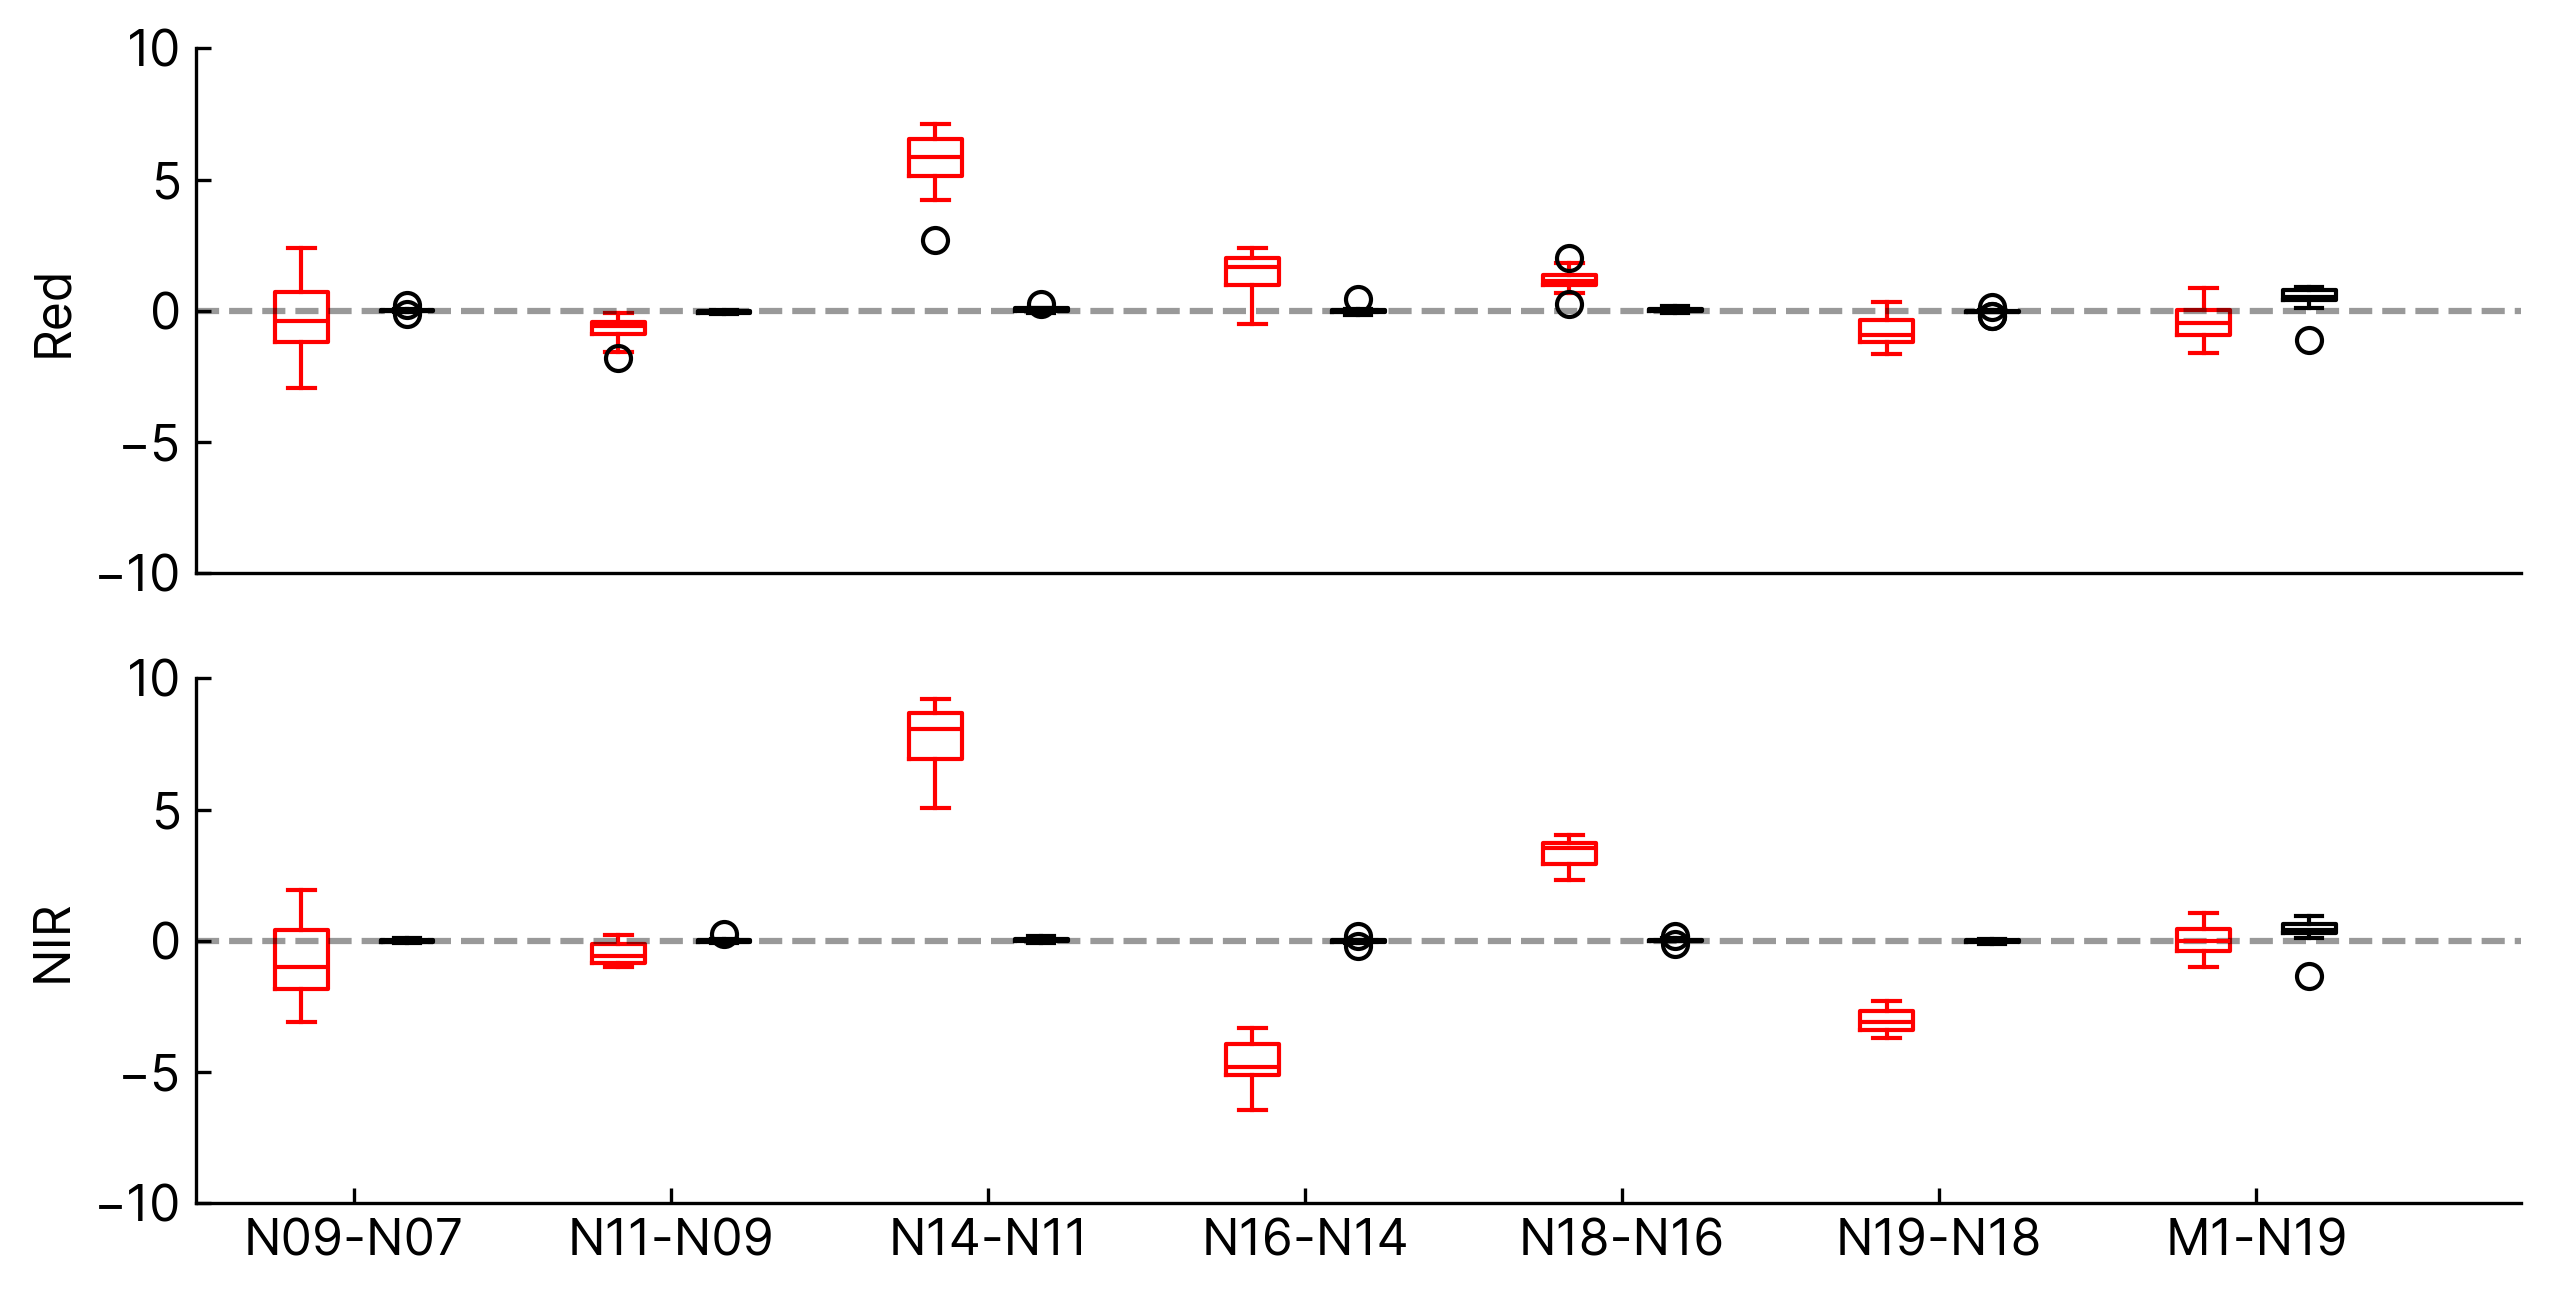

In [87]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
ax = axs.flatten()
bplot0 = ax[0].boxplot(split_diff_df[split_diff_df["varname"]=="RED_LTDR"]["diff"].values,
              positions=np.arange(1, 22, 3))

    
bplot1 = ax[0].boxplot(split_diff_df[split_diff_df["varname"]=="RED_LCREF"]["diff"].values, 
                       positions=np.arange(1, 22, 3)+1)

    
bplot2 = ax[1].boxplot(split_diff_df[split_diff_df["varname"]=="NIR_LTDR"]["diff"].values, 
              positions=np.arange(1, 22, 3))


    
bplot3 = ax[1].boxplot(split_diff_df[split_diff_df["varname"]=="NIR_LCREF"]["diff"].values,
                       positions=np.arange(1, 22, 3)+1)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot0[element], color="red")
    
    
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot1[element], color="k")
    
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot2[element], color="red")
    
    
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot3[element], color="k")
    
    
ax[0].set_ylim(-10,10)
ax[1].set_ylim(-10,10)
ax[0].set_xticks([])
ax[1].set_xticks(np.arange(1, 22, 3)+0.5, split_df.split_name[0:7].values)
for i in range(2):
    ax[i].plot([0,24], [0,0], "k--", alpha=0.4)
    ax[i].set_xlim(0,22)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

ax[0].set_ylabel("Red")
ax[1].set_ylabel("NIR")


plt.show()

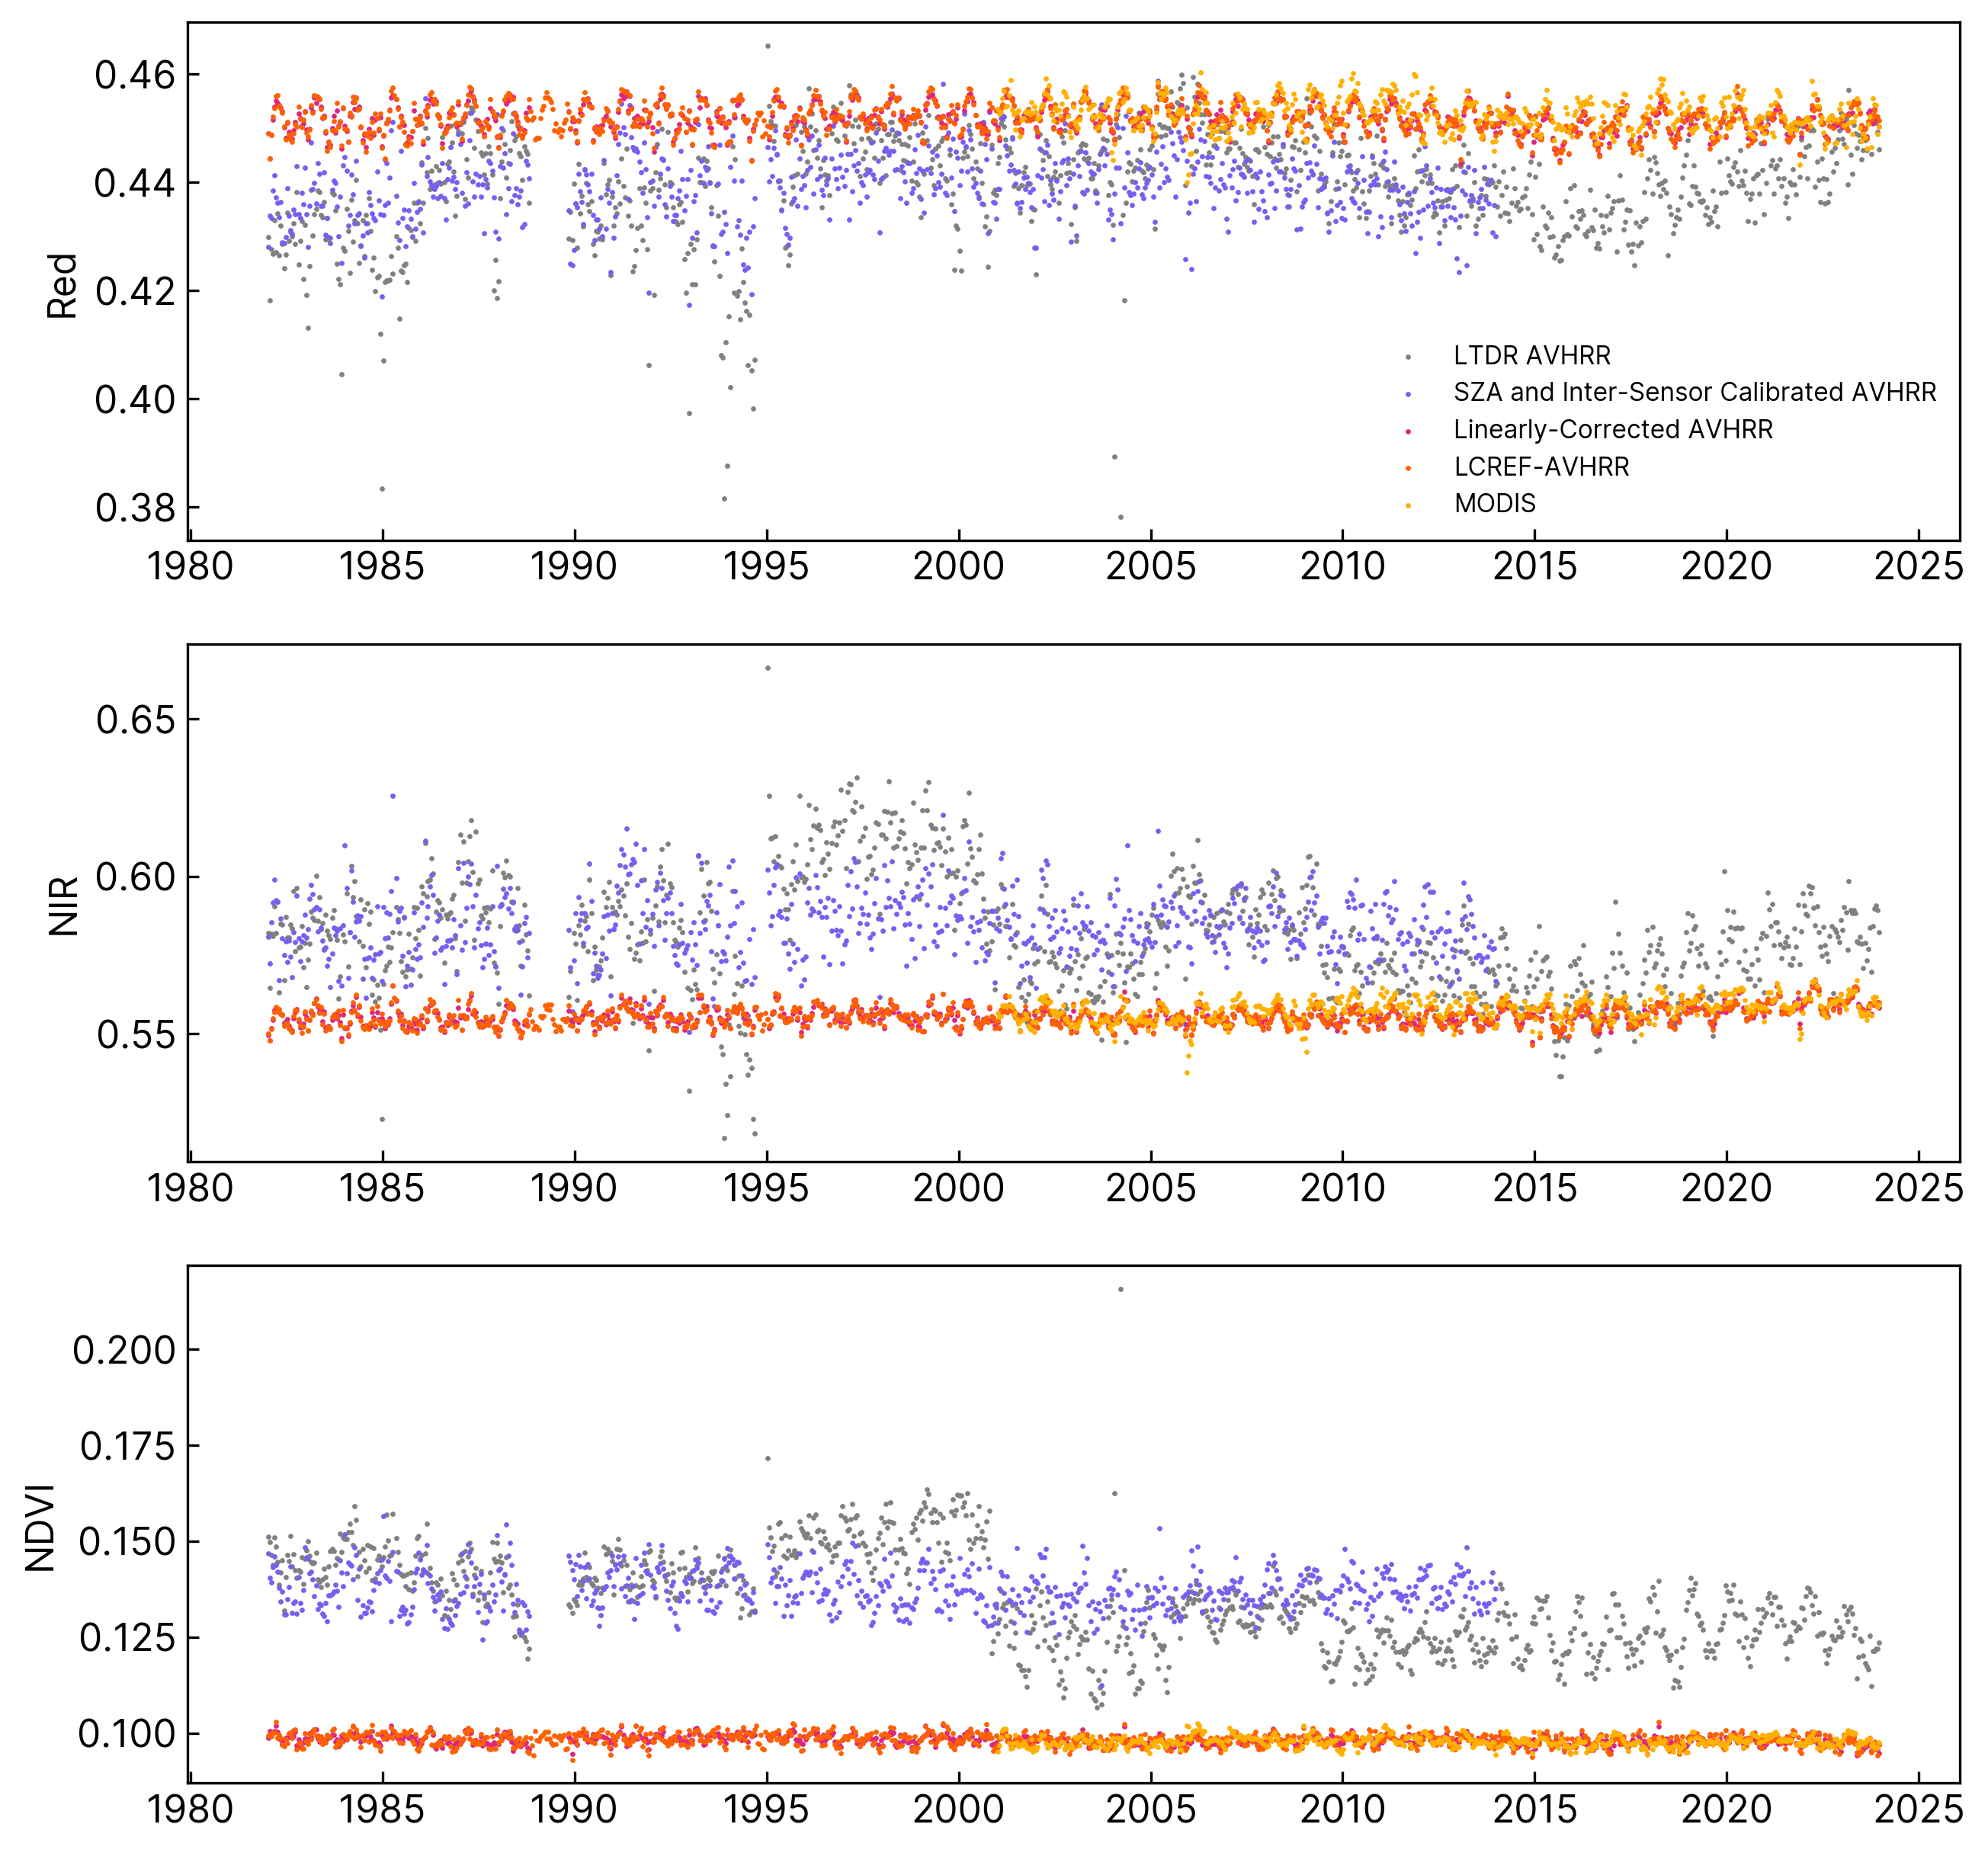

In [97]:
val_idx = np.load("pics_val_idx.npy")
nir_pics = np.load("nir_pics.npy")
red_pics = np.load("red_pics.npy")
sza_pics = np.load("sza_pics.npy")

nir_median =  np.nanmedian(nir_pics[:, val_idx], axis=1)
red_median =  np.nanmedian(red_pics[:, val_idx], axis=1)
sza_median =  np.nanmedian(sza_pics[:, val_idx], axis=1)

ndvi = np.nanmedian((nir_pics[:, val_idx] - red_pics[:, val_idx]) / (nir_pics[:, val_idx] + red_pics[:, val_idx]), axis=1)

fig, axs = plt.subplots(3,1, figsize=(10, 10), dpi=300)
ax = axs.flatten()
nir_sza_median =  np.nanmedian(nir_sza_pics[:, val_idx], axis=1)
red_sza_median =  np.nanmedian(red_sza_pics[:, val_idx], axis=1)


nir_linear_median =  np.nanmedian(nir_linear_pics[:, val_idx], axis=1)
red_linear_median =  np.nanmedian(red_linear_pics[:, val_idx], axis=1)


nir_lcref_median =  np.nanmedian(nir_lcref_pics[:, val_idx], axis=1)
red_lcref_median =  np.nanmedian(red_lcref_pics[:, val_idx], axis=1)

modis_nir_lcref_median =  np.nanmedian(modis_nir_lcref_pics[:, val_idx], axis=1)
modis_red_lcref_median =  np.nanmedian(modis_red_lcref_pics[:, val_idx], axis=1)

ndvi_sza = np.nanmedian((nir_sza_pics[:, val_idx] - red_sza_pics[:, val_idx]) / (nir_sza_pics[:, val_idx] + red_sza_pics[:, val_idx]), axis=1)
ndvi_linear = np.nanmedian((nir_linear_pics[:, val_idx] - red_linear_pics[:, val_idx]) / (nir_linear_pics[:, val_idx] + red_linear_pics[:, val_idx]), axis=1)
ndvi_lcref = np.nanmedian((nir_lcref_pics[:, val_idx] - red_lcref_pics[:, val_idx]) / (nir_lcref_pics[:, val_idx] + red_lcref_pics[:, val_idx]), axis=1)
ndvi_modis = np.nanmedian((modis_nir_lcref_pics[:, val_idx] - modis_red_lcref_pics[:, val_idx]) / (modis_nir_lcref_pics[:, val_idx] + modis_red_lcref_pics[:, val_idx]), axis=1)


colors=["gray", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
ax[0].scatter(time_arr[valid_period], red_median[valid_period], s=0.4, color=colors[0], label="LTDR AVHRR")
ax[0].scatter(time_arr_valid[:-10*24], red_sza_median, s=0.4, color=colors[1], label="SZA and Inter-Sensor Calibrated AVHRR")
ax[0].scatter(time_arr[valid_period], red_linear_median, s=0.4, color=colors[2], label="Linearly-Corrected AVHRR")
ax[0].scatter(time_arr, red_lcref_median, s=0.4, color=colors[3], label="LCREF-AVHRR")
ax[0].scatter(time_arr[-23*24:], modis_red_lcref_median, s=0.4, color=colors[4], label="MODIS")
ax[0].legend(frameon=False, fontsize=8)




ax[0].set_ylabel("Red")

#ax[1].plot(time_avhrr2, nir_avhrr2_median, c="k", alpha=0.6)
#ax[1].plot(time_avhrr3, nir_avhrr3_median, c="k", alpha=0.6)
ax[1].scatter(time_arr[valid_period], nir_median[valid_period], s=0.4, color=colors[0])
ax[1].scatter(time_arr_valid[:-10*24], nir_sza_median, s=0.4, color=colors[1])
ax[1].scatter(time_arr[valid_period], nir_linear_median, s=0.4, color=colors[2])
ax[1].scatter(time_arr, nir_lcref_median, s=0.4, color=colors[3])
ax[1].scatter(time_arr[-23*24:], modis_nir_lcref_median, s=0.4, color=colors[4])



ax[1].set_ylabel("NIR")
#ax[1].plot(time_arr_valid, np.load("../../data/pics_cal_nir_median.npy")[:-2][valid_period])


ax[2].scatter(time_arr[valid_period], ndvi[valid_period], s=0.4, color=colors[0])
ax[2].scatter(time_arr_valid[:-10*24], ndvi_sza, s=0.4, color=colors[1])
ax[2].scatter(time_arr[valid_period], ndvi_linear, s=0.4, color=colors[2])
ax[2].scatter(time_arr, ndvi_lcref, s=0.4, color=colors[3])
ax[2].scatter(time_arr[-23*24:], ndvi_modis, s=0.4, color=colors[4])


ax[2].set_ylabel("NDVI")
plt.show()